### Loading the weights of the trained model

In [3]:
# path_model = "/home/xnmaster/Project/model_MobileNet_V3.pt"
path_model = r"C:\Users\Joan\Desktop\Deep_Learning_project\best_model_transformer_simpler.pt"

In [4]:
from models.models import *
from utils.utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = dict(
        epochs=35,
        classes=28,
        batch_size=16,
        batch_size_val_test=25,
        learning_rate=0.00005,
        patience=10,
        heads=3,
        depth=2,
        fc_transformer=315,
        dataset="ConText",
        architecture="Transformer",
        cnn = "convnext_tiny",
        weights = "DEFAULT")

model, train_loader, test_loader, val_loader = make_test(config)
model.load_state_dict(torch.load(path_model))
model.eval()

Transformer(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm(

In [5]:
def test_acc(model, test_loader):
    model.eval()
    # model.train()
    with torch.no_grad():
        correct, total = 0, 0
        for labels, img, text, text_mask in test_loader:
            img, labels, text, text_mask = img.to(device), labels.to(device), text.to(device), text_mask.to(device)
            outputs = model(img, text, text_mask)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        return correct / total

In [6]:
test_accuracy = test_acc(model, test_loader)

Accuracy of the model on the 4851 test images: 78.726036%


In [7]:
def get_y_pred(model, loader):
    model.eval()
    # model.train()
    real = []
    pred = []
    with torch.no_grad():
        correct, total = 0, 0
        for labels, img, text, text_mask in loader:
            img, labels, text, text_mask = img.to(device), labels.to(device), text.to(device), text_mask.to(device)
            outputs = model(img, text, text_mask)
            pred.extend((outputs.data.max(1, keepdim=True)[1]).tolist())
            real.extend(labels.tolist())
    return real, pred

In [8]:
y_test, y_pred = get_y_pred(model, test_loader)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Credit: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf, group_names=None, categories='auto', count=False, percent=False, cbar=True, xyticks=True, xyplotlabels=True, sum_stats=True, figsize=None, cmap='Blues', title=None):
    
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [10]:
label2class = {1: "Bakery",
10:"Dry Cleaner",
11:"Funeral",
12:"Hotspot",
13:"MassageCenter",
14:"MedicalCenter",
15:"PackingStore",
16:"Pawnshop",
17:"PetShop",
18:"Pharmacy",
19:"Pizzeria",
2:"Barber",
20:"RepairShop",
21:"Restaurant",
22:"School",
23:"SteakHouse",
24:"Tavern",
25:"TeaHouse",
26:"Theatre",
27:"Tobacco",
28:"Motel",
3:"Bistro",
4:"Bookstore",
5:"Cafe",
6:"ComputerStore",
7:"CountryStore",
8:"Diner",
9:"DiscounHouse"}

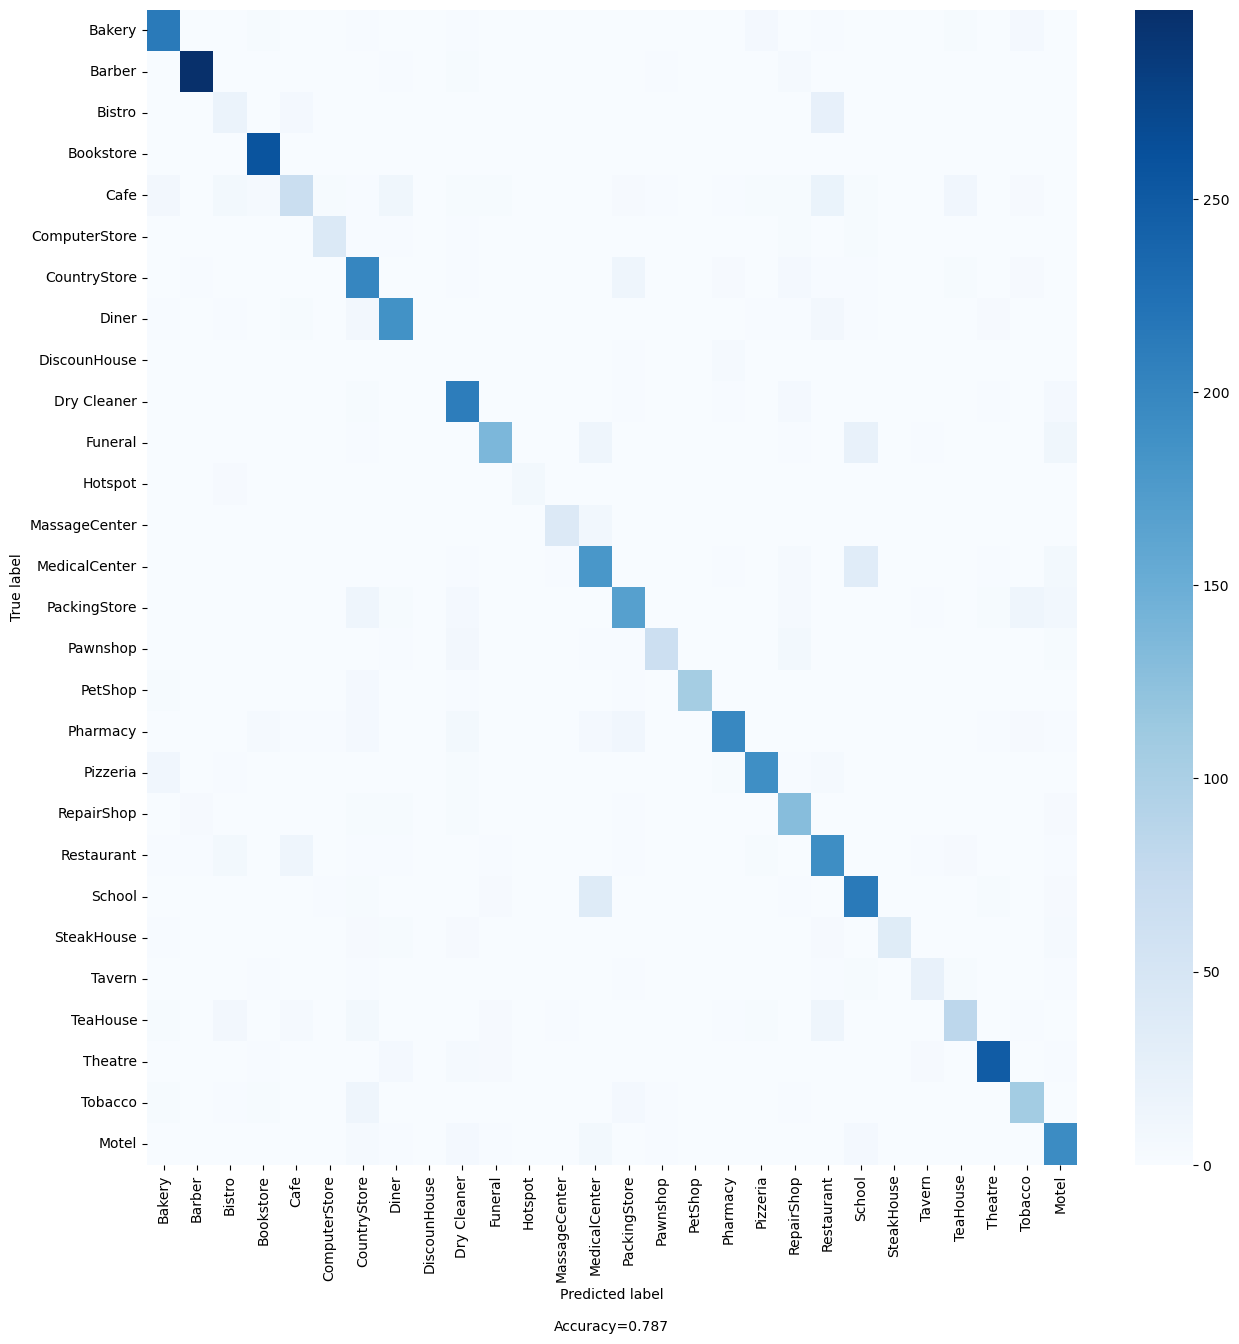

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns
categories = [label2class[i] for i in range(1, 29)]
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, cmap='Blues', categories=categories, figsize=(15, 15))
plt.show()

In [12]:
dict_recalls = {}
for i in range(cm.shape[0]):
    row = cm[i, :]
    well_predicted = cm[i, i]
    if sum(row) != 0:
        recall = well_predicted/sum(row)
        dict_recalls[label2class[i+1]] = recall
    else:
        dict_recalls[label2class[i+1]] = 0

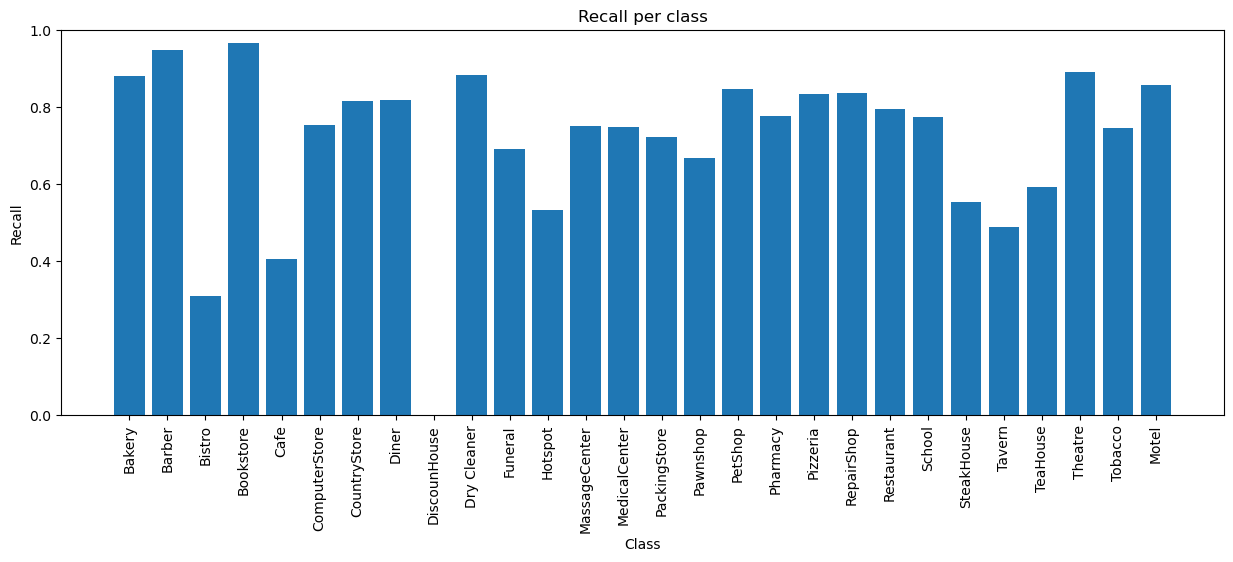

In [13]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(dict_recalls)), [v for k,v in dict_recalls.items()])
plt.xticks(range(len(dict_recalls)), [k for k,v in dict_recalls.items()],rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per class')
plt.ylim(0, 1)
plt.show()

In [14]:
dict_precisions = {}
for i in range(cm.shape[0]):
    column = cm[:, i]
    well_predicted = cm[i, i]
    if sum(column) != 0:
        precision = well_predicted/sum(column)
        dict_precisions[label2class[i+1]] = precision
    else:
        dict_precisions[label2class[i+1]] = 0

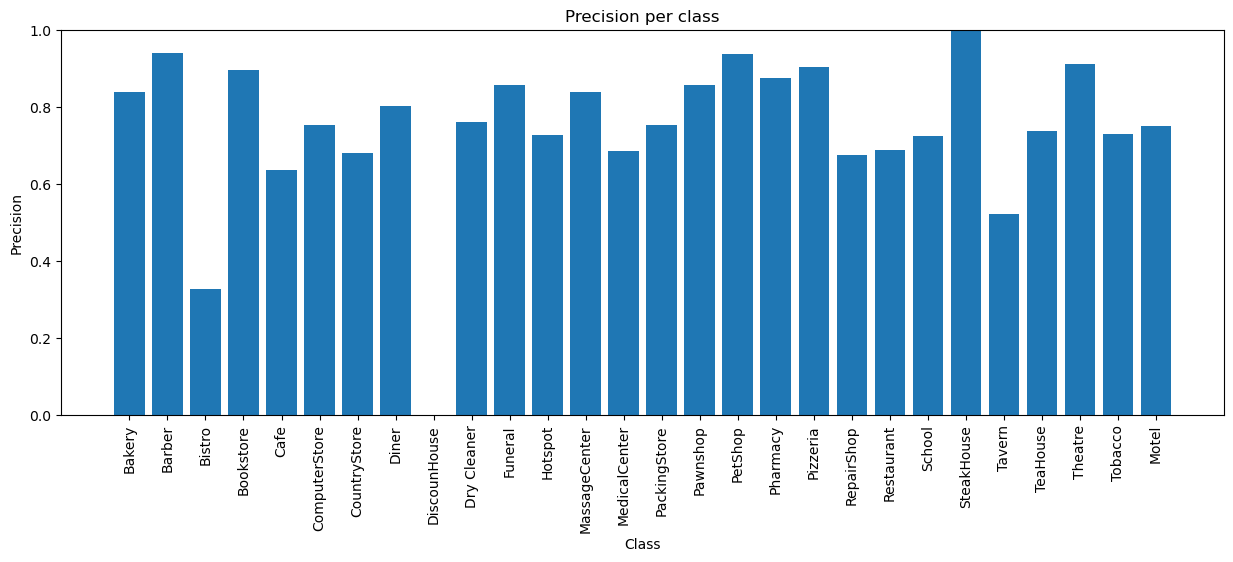

In [15]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(dict_precisions)), [v for k,v in dict_precisions.items()])
plt.xticks(range(len(dict_precisions)), [k for k,v in dict_precisions.items()],rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per class')
plt.ylim(0, 1)
plt.show()

In [16]:
dict_f1_scores = {}
for k in dict_precisions.keys():
    if (dict_precisions[k]+dict_recalls[k]) != 0:
        dict_f1_scores[k] = (2*dict_precisions[k]*dict_recalls[k])/(dict_precisions[k]+dict_recalls[k])
    else:
        dict_f1_scores[k] = 0

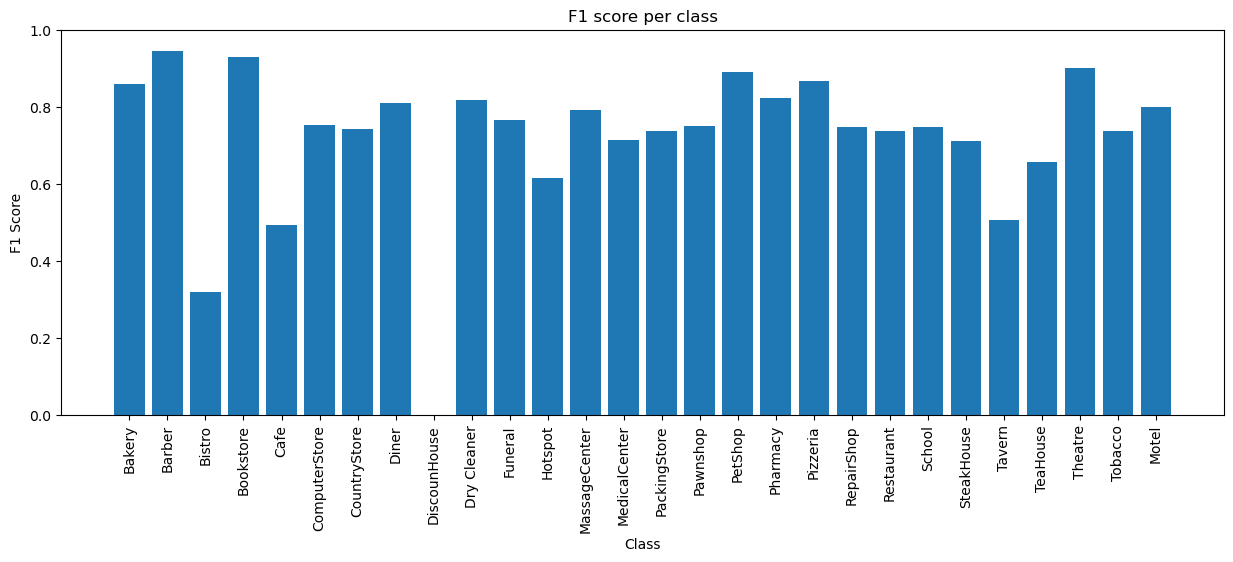

In [17]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(dict_f1_scores)), [v for k,v in dict_f1_scores.items()])
plt.xticks(range(len(dict_f1_scores)), [k for k,v in dict_f1_scores.items()],rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 score per class')
plt.ylim(0, 1)
plt.show()

In [18]:
print("Mean precision:", np.mean([v for v in dict_precisions.values()]))
print("Mean recall:", np.mean([v for v in dict_recalls.values()]))
print("Mean F1 score:", np.mean([v for v in dict_f1_scores.values()]))

Mean precision: 0.7434957228638003
Mean recall: 0.7104379975548367
Mean F1 score: 0.7207320743915312


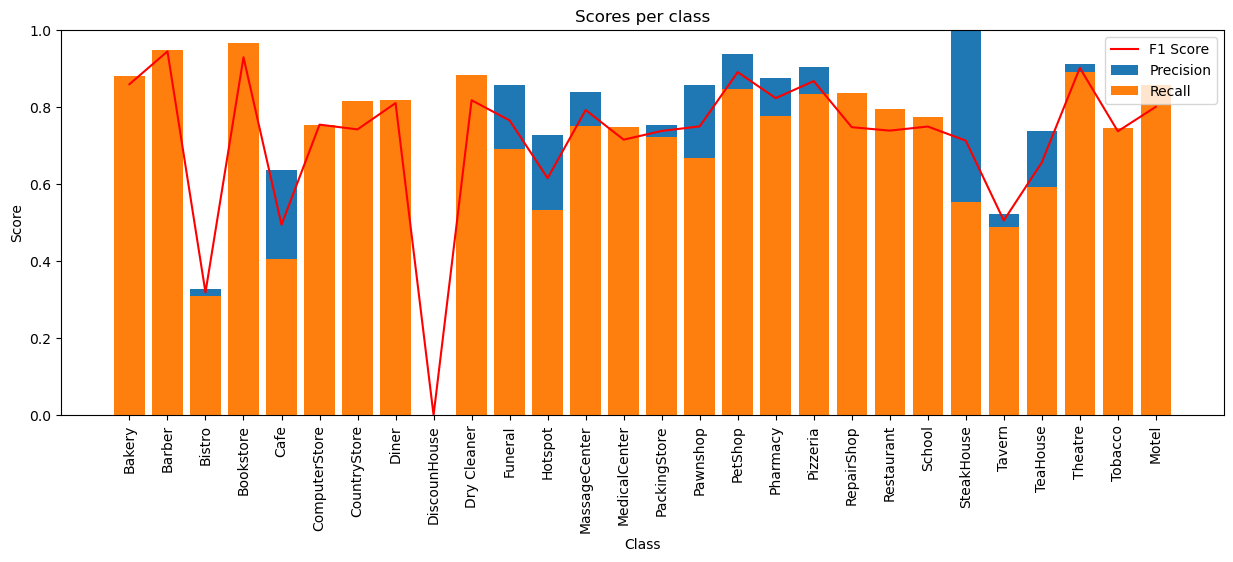

In [19]:
# make a plot where for each class we have the rpecision and recall in the same bar and the f1 score as a line

plt.figure(figsize=(15, 5))

plt.bar(range(len(dict_precisions)), [v for k,v in dict_precisions.items()], label="Precision")
plt.bar(range(len(dict_recalls)), [v for k,v in dict_recalls.items()], label="Recall")

plt.plot(range(len(dict_f1_scores)), [v for k,v in dict_f1_scores.items()], label="F1 Score", color="red")
plt.xticks(range(len(dict_precisions)), [k for k,v in dict_precisions.items()],rotation=90)
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Scores per class')

plt.ylim(0, 1)
plt.legend()
plt.show()

In [20]:
def de_normalize(images):
  t = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                           std=[1/0.229, 1/0.224, 1/0.255])
  
  return t(images)

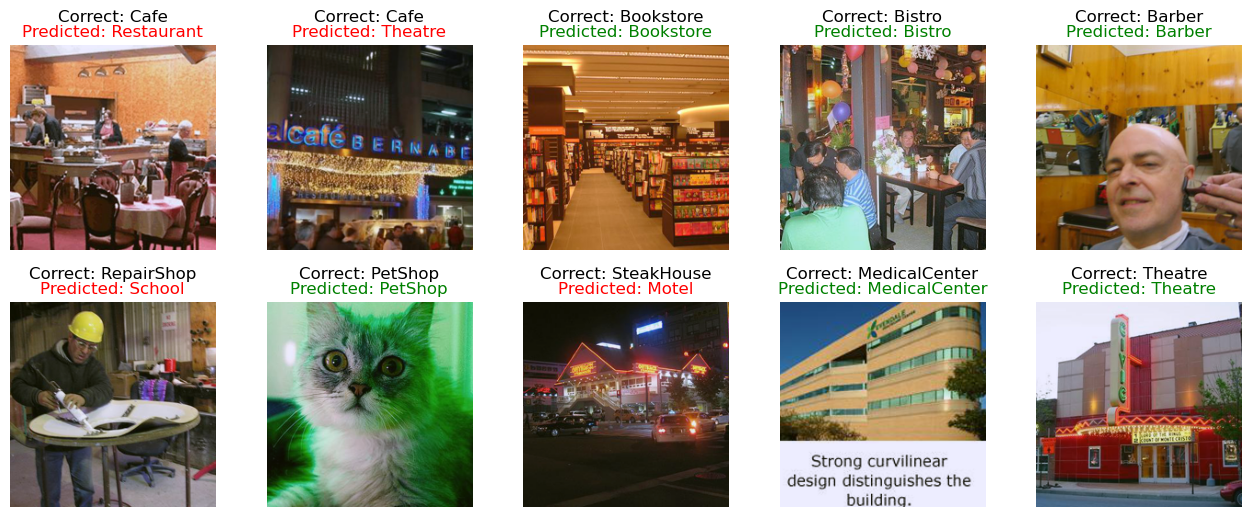

In [30]:
lenght_dataset = len(test_loader.dataset)
plt.figure(figsize=(16, 6))
plt.subplots_adjust(hspace=0.25)
for i in range(10):
    plt.subplot(2, 5, i + 1) 

    idx = np.random.randint(0, lenght_dataset)
    label, img, txt, txt_mask = test_loader.dataset[idx]
    img = img.unsqueeze(0)
    txt = torch.tensor(txt).unsqueeze(0)
    txt_mask = torch.tensor(txt_mask).unsqueeze(0)
    with torch.no_grad():
        output = model(img.to(device), txt.to(device), txt_mask.to(device))
        _, pred = torch.max(output, 1)

    if pred == label:
      color = 'green'
    else:
      color = "red"

    plt.title("Predicted: "+ str(label2class[int(pred.to("cpu").numpy())+1]), color=color)
    plt.text(0.5, 1.1, "Correct: "+ str(label2class[label+1]), color="black", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)

    img = img.reshape(3, 224, 224)
    img = de_normalize(img)
    img = img.permute(1, 2, 0).numpy() 
    img -= img.min()
    img = (img / img.max()) * 255
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
plt.show()

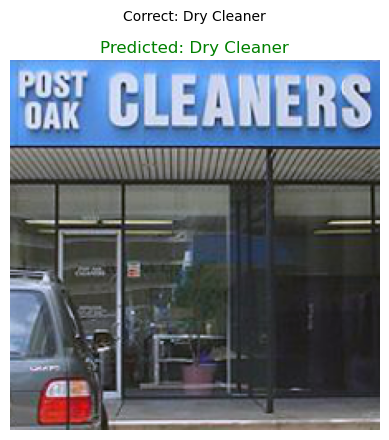

In [22]:
idx = np.random.randint(0, lenght_dataset)
label, img, txt, txt_mask = test_loader.dataset[idx]
img = img.unsqueeze(0)
txt = torch.tensor(txt).unsqueeze(0)
txt_mask = torch.tensor(txt_mask).unsqueeze(0)
with torch.no_grad():
    output = model(img.to(device), txt.to(device), txt_mask.to(device))
    prob, pred = torch.max(torch.nn.functional.softmax(output, dim=1), 1)

if pred == label:
    color = 'green'
else:
    color = "red"

prob = prob.to("cpu").numpy()[0]
prob = round(prob*100, 1)
plt.title("Predicted: "+ str(label2class[int(pred.to("cpu").numpy())+1]), color=color)
plt.text(0.5, 1.1, "Correct: "+ str(label2class[label+1]), color="black", fontsize=10, ha='center', va='bottom', transform=plt.gca().transAxes)


img = img.reshape(3, 224, 224)
img = de_normalize(img)
img = img.permute(1, 2, 0).numpy() 
img -= img.min()
img = (img / img.max()) * 255
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.show()

In [23]:
y_pred_temp = [i[0] for i in y_pred]

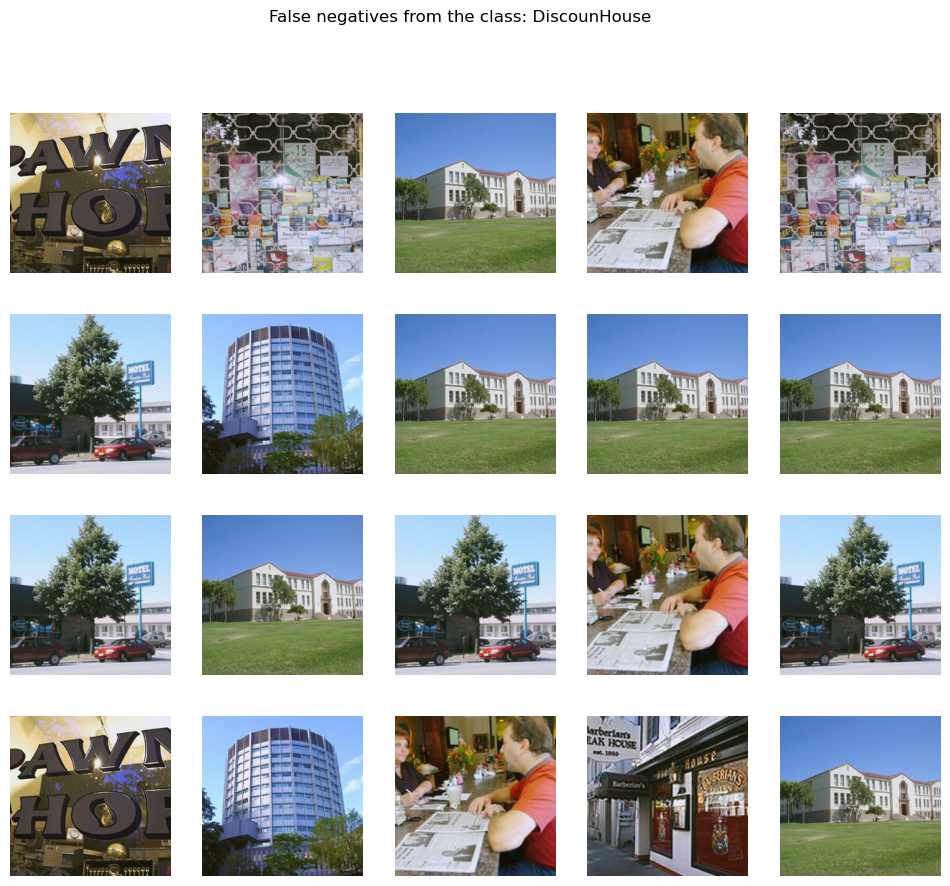

In [24]:
# create a plot of false negative from the worse class in terms of recall
class_to_show = "DiscounHouse"
num_class_to_show = [k for k,v in label2class.items() if v == class_to_show][0] - 1

index = []
for i in range(len(y_pred_temp)):
    if y_pred_temp[i] != num_class_to_show and y_test[i] == num_class_to_show:
        index.append(i) 

num_imgs_to_show = 20
fig, ax = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle("False negatives from the class: " + class_to_show)

import random 
for i in range(num_imgs_to_show):
    random_index = random.choice(index)
    plt.subplot(4, 5, i + 1)

    label, img, txt, txt_mask = test_loader.dataset[random_index]
    img = img.reshape(3, 224, 224)
    img = de_normalize(img)
    img = img.permute(1, 2, 0).numpy() 
    img -= img.min()
    img = (img / img.max()) * 255
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
plt.show()
    

Text(0.5, 1.0, 'Distribution of false negative of the class: DiscounHouse')

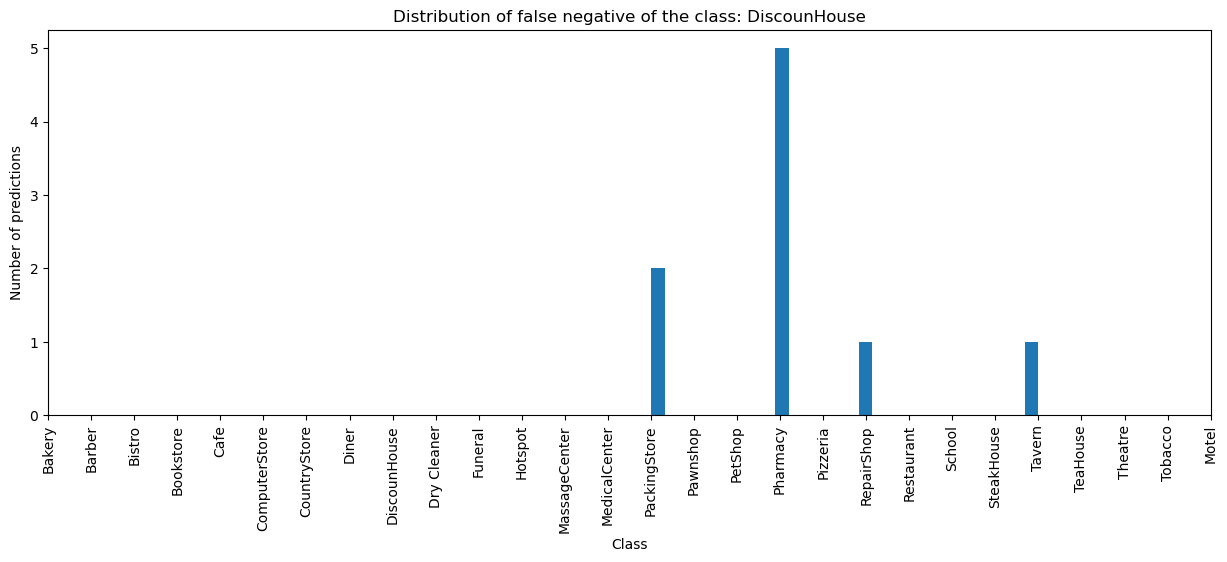

In [25]:
y_pred_class = []
for i in index:
    y_pred_class.append(y_pred_temp[i])

plt.figure(figsize=(15, 5))

plt.hist(y_pred_class, bins=28)
plt.xticks(range(28), [label2class[i+1] for i in range(28)],rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of predictions')
plt.title('Distribution of false negative of the class: ' + class_to_show)

Text(0.5, 1.0, 'Predictions of the class: DiscounHouse')

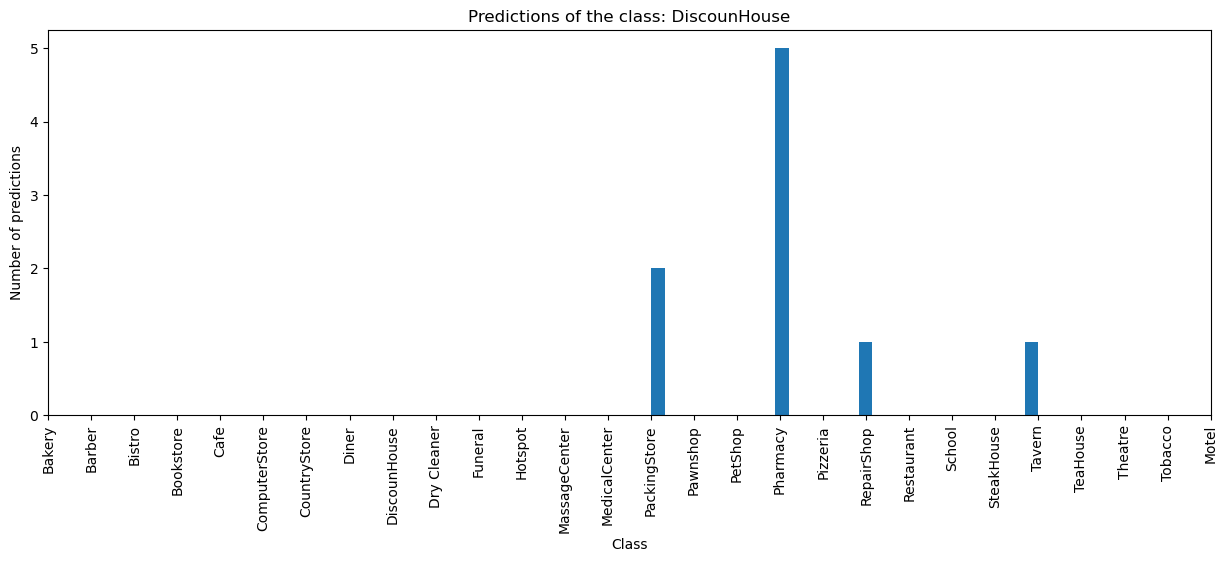

In [26]:
index = []
for i in range(len(y_pred_temp)):
    if y_test[i] == num_class_to_show:
        index.append(i)

y_pred_class = []
for i in index:
    y_pred_class.append(y_pred_temp[i])

#plot a histogram of the predictions of the class
plt.figure(figsize=(15, 5))

plt.hist(y_pred_class, bins=28)
plt.xticks(range(28), [label2class[i+1] for i in range(28)],rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of predictions')
plt.title('Predictions of the class: ' + class_to_show)